In [ ]:
!rm -r sample_data

In [1]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 25.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import math
import os
import requests
import csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
# from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler

from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.Chem import rdMolDescriptors

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score, recall_score, f1_score


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !sudo add-apt-repository ppa:alessandro-strada/ppa
# !sudo apt-get update
# !sudo apt-get install google-drive-ocamlfuse

In [ ]:
# !google-drive-ocamlfuse -headless -label me -id 732312013137-mflc00unq1d884qjbk1v0rukai8grde4.apps.googleusercontent.com -secret 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 

In [ ]:
# !mkdir ./my_mnt_dir
# !google-drive-ocamlfuse -label me ./my_mnt_dir

## EXTRACT DATA
CSV file to be present in local machine.<br>
FIle name is data.csv

In [4]:
# Downloading the data from the GitHub repository
if os.path.exists("data.csv"):
  print("Data already downloaded, skipping download....")
else:
  url = 'https://github.com/sriskid/hts_active_learning/raw/main/data.csv'
  res = requests.get(url, allow_redirects=True)
  
  with open('data.csv','wb') as f:
    print("Downloading data....")
    f.write(res.content)

In [5]:
data = []
with open('data.csv', 'r') as csvfile: 
    reader = csv.reader(csvfile, skipinitialspace=True)
    data.append(tuple(next(reader))) # header
    for ID, SMILE, B, RES, is_active in reader:
        data.append((ID, SMILE, B, RES, is_active)) #append data as tuple

# remove header
data = data[1:]
maxlen = len(data)
print('Number of entries processed: ', maxlen)

Number of entries processed:  29537


In [6]:
# Get only the SMILES data
SMILES = []
for i in data:
    SMILES.append(i[1])

In [7]:
SMILES[0:2] 

['c1(c2c([nH]c1)ccc(c2)OCc1ccccc1)CN(C)C ',
 'c12[nH]c3c(c1CCN=C2C)ccc(c3)O.Cl.O ']

## ONE-HOT ENCODING OF SMILES
This will help in vectrorizing smiles data.<br>
This section will use the tokenizer function that is provided in tensorflow, and we will use keras as the front-end to access the function.<br>
Credit: https://www.kaggle.com/code/art3mis/220221-getting-started-with-smiles <br>
Inspiration: https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76

In [9]:
# Create a tokenizer for vectorization. 
tokenizer = Tokenizer(char_level=True, lower=False) 
    # char_level: If True, every character will be treated as a token.
    # lower: Whether to convert the texts to lowercase.

tokenizer.fit_on_texts(SMILES)
    # used to create the vocabulary index based on the word frequency in the text data.

    # ^tokenizer will have a vocabulary of all the unique words in the input text documents, 
    # and each word will be mapped to a unique integer index. 

# Encoding text_to_sequences
sequences = tokenizer.texts_to_sequences(SMILES)
    # tokenizer's vocabulary can then be used to convert the text data into a *sequence of integer indexes* using the texts_to_sequences() method of the Tokenizer object.

pad_data = pad_sequences(sequences, maxlen = len(max(sequences, key=len)))
    # pads sequences to the same length. It takes as input a list of sequences (e.g., sentences), 
    # and pads the sequences to the longest seq length. 
    # The resulting sequences are stored in a numpy array.

# print ('Encoded string:',pad_data[0])

In [10]:
#sequences_to_text decodes
print ('Decoded string:',tokenizer.sequences_to_texts(pad_data[0:1]))

Decoded string: ['c 1 ( c 2 c ( [ n H ] c 1 ) c c c ( c 2 ) O C c 1 c c c c c 1 ) C N ( C ) C  ']


In [11]:
def decodeOH2SMILES(array, tokenizer):
    # Converts one-hot encoded sequences back to SMILES strings.
    output = tokenizer.sequences_to_texts(array)

    #Modify this if you change the start or end token.
    disallowed_characters = 'E! ' # == unspecified charge* drop it.

    for character in disallowed_characters:
        output = [i.replace(character,'') for i in output]
    return output

In [12]:
decoded_smiles = decodeOH2SMILES(pad_data[0:2],tokenizer)
print(decoded_smiles)

['c1(c2c([nH]c1)ccc(c2)OCc1ccccc1)CN(C)C', 'c12[nH]c3c(c1CCN=C2C)ccc(c3)O.Cl.O']


In [13]:
SMILES[0]

'c1(c2c([nH]c1)ccc(c2)OCc1ccccc1)CN(C)C '

## MOLECULAR FINGERPRINT ENCODING OF SMILES
This will help in converting smiles data so that it can be used for applying ML techniques. This is more often used (from surveying)<br>
Credit: https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76

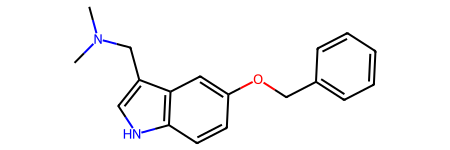

In [14]:
# Drawing molecules
mol = Chem.MolFromSmiles(SMILES[0])
mol

In [15]:
# We will be using RDK fingerprint to vectorize all our SMILES structures
fingerprints = []
for i in range(len(SMILES)):
    mol = Chem.MolFromSmiles(SMILES[i])
    fingerprint_rdk = np.array(RDKFingerprint(mol))
    fingerprints.append(fingerprint_rdk)
fingerprints = np.array(fingerprints)
fingerprints

[00:59:06] WARNING: not removing hydrogen atom without neighbors


array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0]])

## VISUALIZATION OF DATA
Data is obtained from the following paper - https://doi.org/10.1371/journal.pcbi.1010613 <br>
In this paper (and a previous paper of theirs), they conducted a series of HTS to obtain the Average B-score and residual values for a series of small molecules to see their potency against Burkholderia cenocepacia.<br>
Quoting the paper,<br>

"The dataset used in the ML approach consisted of 29,537 compounds with residual growth (RG) values and average B-scores. The RG measures the ratio of bacterial growth in the presence and absence of the compounds. The B-score measures relative potency that adjusts the RG for any screening artifacts resulting from well position (row and column) in the assay plate during the HTS. The B-score is inversely proportional to compound potency, where negative B-scores indicate greater growth inhibitory activity of the compounds. To binarize the compounds, the previously established average B-score threshold of -17.5 was chosen [https://doi.org/10.1371/journal.pone.0128587]. Overall, 256 small molecules were classified as growth inhibitory."

Staying true to the essence of the paper, we will be setting a threshold of -17.5 for B-score in our data as well, i.e. below this threshold, the compound is labeled active, and otherwise inactive.

In [16]:
# Checking data for number of active compounds
# idx - ID, SMILE, B, RES, is_active
count = 0
for i in range(len(data)):
    if float(data[i][2]) <= -17.5:
        if float(data[i][4]) == 1:
            count += 1
print("Number of active compounds =",count)
# This follows what is mentioned in the paper.

Number of active compounds = 256


In [17]:
# Get the B-score values
Bscores = []
active = []
is_active = []
for i in range(len(data)):
    Bscores.append(float(data[i][2]))

    is_active.append(float(data[i][4]))

    if float(data[i][4]) == 0:
        active.append("Inactive")
    else:
         active.append("Active")
            
compound_idx = np.arange(len(Bscores))
is_active = np.array(is_active)

[Text(0.5, 0, 'Compound Index'), Text(0, 0.5, 'B-Score')]

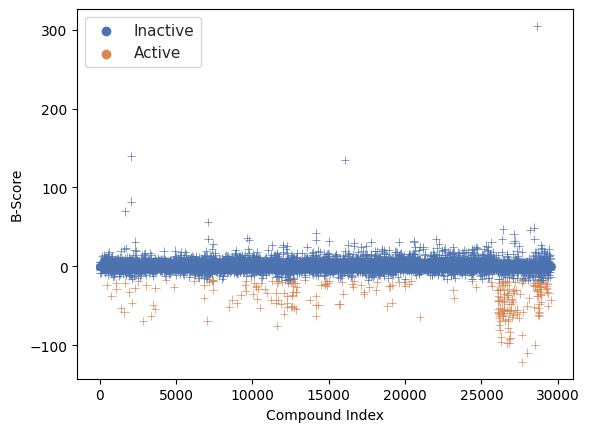

In [18]:
# Visualizing data
# Plot B-scores

fig, ax = plt.subplots()
# plt.scatter(compound_idx[0:100], Bscores[0:100], c ="blue")
sns.set(style='whitegrid')
sns.scatterplot(x=compound_idx,
                    y=Bscores,
                    hue=active, marker='+')

# ax.set_ylim(-500, 100)
ax.set(xlabel='Compound Index', ylabel='B-Score')

## SPLITTING OF DATA
This is an important section because our data is heavily unbalanced. Therefore, we do random undersampling of the major class.


In [19]:
# Includes undersampling of major label to make classes balanced.
def train_test_split(X_resampled, y_resampled, split_ratio=0.05):
    # rus = RandomUnderSampler(random_state=10) # to make it reproducible -- random_state=rng => 
    # X_resampled, y_resampled = rus.fit_resample(fingerprints, active)
    
    # split data
    # get random permutations
    rand_idx = np.random.permutation(len(X_resampled))
    train_size = round(len(X_resampled)*split_ratio)
    
    trainX = X_resampled[rand_idx[0:train_size]]
    testX = X_resampled[rand_idx[train_size:len(X_resampled)]]
    trainY = y_resampled[rand_idx[0:train_size]]
    testY = y_resampled[rand_idx[train_size:len(X_resampled)]]
    
    return trainX, trainY, testX, testY

In [20]:
# Includes undersampling of major label to make classes balanced.
def Get_RUS(fingerprints, active, rng):
    rus = RandomUnderSampler(random_state=rng) # to make it reproducible -- random_state=rng
    X_resampled, y_resampled = rus.fit_resample(fingerprints, active)
    return X_resampled, y_resampled


Expected Model Change

## IMPLEMENTING LOGISTIC REGRESSION ON MOLECULAR FINGERPRINTS
Logistic regression will be our base learner for this project. Below is the passive learning implementation for the same.

In [30]:
class LogR():
    '''
    logistic regression class
    '''
    def __init__(self, x, y):
        self.trainX = x
        self.trainY = y.reshape(len(y),)
        self.model = LogisticRegression(random_state=0, max_iter=500)

    def fit(self):
        self.model.fit(self.trainX, self.trainY)
        
    def predict(self, x):
        return self.model.predict(x)

    def predict_prob(self, x):
        return self.model.predict_proba(x)

    def predict_logprob(self, x):
        return self.model.predict_log_proba(x)

    def generate_acc(self, pred, true):
        return accuracy_score(true, pred)

In [24]:
split_ratio = 0.05

In [29]:
X_resampled, y_resampled = Get_RUS(fingerprints, is_active, rng=10)
trainX, trainY, testX, testY = train_test_split(X_resampled, y_resampled, split_ratio=split_ratio)
len_test = len(testX)
N_rounds = int(len_test) - 10
init_train_size = round(len(trainX)*(split_ratio))

print("Number of rounds =",N_rounds)

X_resampled, y_resampled = Get_RUS(fingerprints, is_active, rng=10)
X_resampled.shape

Number of rounds = 476


(512, 2048)

In [51]:
def run_l_simulations_uncertainty_sampling(fingerprints, is_active, m = 475):
    '''
    fingerprints: original data (np array)
    is_active: label for original data (int)
    
    returns l by m np.array
    (1) l number of simulations
    (2) m rounds of updates 
    '''
    assert len(fingerprints) == len(is_active)

    X_resampled, y_resampled = Get_RUS(fingerprints, is_active, rng=10)
    trainX, trainY, testX, testY = train_test_split(X_resampled, y_resampled, split_ratio=split_ratio)
    len_test = len(testX)
    N_rounds = int(len_test) - 10
    init_train_size = round(len(trainX)*(split_ratio))

    print("Number of rounds =",N_rounds)

    X_resampled, y_resampled = Get_RUS(fingerprints, is_active, rng=10)

    N_simulations = 10
    
    # store accuracy here    
    l_sim_accuracy_ls = np.zeros((N_simulations, N_rounds))
    l_sim_precision_ls = np.zeros((N_simulations, N_rounds))
    l_sim_recall_ls = np.zeros((N_simulations, N_rounds))
    l_sim_f1_ls = np.zeros((N_simulations, N_rounds))
    
    X_resampled, y_resampled = Get_RUS(fingerprints, is_active, rng=10)
    
    for i in range(N_simulations): # l simulations
        print('simulations: ',i)
        np.random.seed(i+10)
        trainX, trainY, testX, testY = train_test_split(X_resampled, y_resampled, split_ratio=0.05)
        
        # for m updates
        for j in range(N_rounds): 
          print('simulations: ',i)
          # Get performance metrics on the logistic regression model
          logreg = LogR(trainX, trainY)
          logreg.fit()
          pred_y = logreg.predict(testX)
          prev_acc = logreg.generate_acc(pred_y, testY)

          l_sim_accuracy_ls[i, j] = prev_acc

          # calculate precision, recall, and F1 score
          precision = precision_score(testY, pred_y)
          l_sim_precision_ls[i, j] = precision
          recall = recall_score(testY, pred_y)
          l_sim_recall_ls[i, j] = recall
          f1 = f1_score(testY, pred_y)
          l_sim_f1_ls[i, j] = f1

          # Get the next point to take into training data
          prob_pred = logreg.predict_prob(testX)
          # prob_log_pred = logreg.predict_logprob(testX)
          lc = 1 - np.argmax(prob_pred, axis=1)
          print(lc.size)
          max_idx = np.argmax(lc)
          print(max_idx.shape, max_idx)


          # include the max idx data to the training set
          trainX = np.concatenate((trainX,testX[[max_idx]]), axis=0)
          trainY = np.concatenate((trainY,testY[[max_idx]]), axis=0)
          # remove them from test data
          testX = np.delete(testX, max_idx, axis=0)
          testY = np.delete(testY, max_idx, axis=0)

          print(len(trainX), len(testX))

          print('accuracy', l_sim_accuracy_ls[i,j] )
          print('precision', l_sim_precision_ls[i,j] )
          print('recall', l_sim_recall_ls[i,j])
          print('f1', l_sim_f1_ls[i,j])
          print()

    # np.save(f'/content/my_mnt_dir/cmu/sem4/auto/prj/10_sim_uncertainty_accuracy.npy',l_sim_accuracy_ls)
    # np.save(f'/content/my_mnt_dir/cmu/sem4/auto/prj/10_sim_uncertainty_precision.npy',l_sim_precision_ls)
    # np.save(f'/content/my_mnt_dir/cmu/sem4/auto/prj/10_sim_uncertainty_recall.npy',l_sim_recall_ls)
    # np.save(f'/content/my_mnt_dir/cmu/sem4/auto/prj/10_sim_uncertainty_recall.npy',l_sim_f1_ls)
    
    return l_sim_accuracy_ls, l_sim_precision_ls, l_sim_recall_ls, l_sim_f1_ls

In [52]:
'''
simulations: 50
seed = 4 부터 시작하자*

initial random sampling: 5% of data

fingerprints: data
is_active: label

Log:
*results using seed4 saved in drive

'''

run_10_sim = run_l_simulations_uncertainty_sampling(fingerprints, is_active)

Streaming output truncated to the last 5000 lines.
precision 0.8111111111111111
recall 1.0
f1 0.8957055214723927

simulations:  8
89
() 0
424 88
accuracy 0.8202247191011236
precision 0.8202247191011236
recall 1.0
f1 0.9012345679012346

simulations:  8
88
() 0
425 87
accuracy 0.8295454545454546
precision 0.8295454545454546
recall 1.0
f1 0.906832298136646

simulations:  8
87
() 0
426 86
accuracy 0.8275862068965517
precision 0.8275862068965517
recall 1.0
f1 0.9056603773584906

simulations:  8
86
() 0
427 85
accuracy 0.8255813953488372
precision 0.8255813953488372
recall 1.0
f1 0.9044585987261146

simulations:  8
85
() 0
428 84
accuracy 0.8235294117647058
precision 0.8235294117647058
recall 1.0
f1 0.9032258064516129

simulations:  8
84
() 0
429 83
accuracy 0.8214285714285714
precision 0.8214285714285714
recall 1.0
f1 0.9019607843137255

simulations:  8
83
() 0
430 82
accuracy 0.8313253012048193
precision 0.8313253012048193
recall 1.0
f1 0.9078947368421052

simulations:  8
82
() 0
431 81
ac

In [54]:
# run_10_sim

In [56]:
# Average over all simulations
avg_acc = np.mean(run_10_sim[0], axis=0)
avg_std = np.std(run_10_sim[0], axis=0)

avg_prec = np.mean(run_10_sim[1], axis=0)
std_prec = np.std(run_10_sim[1], axis=0)
avg_recall = np.mean(run_10_sim[2], axis=0)
std_recall = np.std(run_10_sim[2], axis=0)
avg_f1 = np.mean(run_10_sim[3], axis=0)
std_f1 = np.std(run_10_sim[3], axis=0)


In [59]:
# Save the array to a file
np.save('/content/uncer_performance.npy', avg_acc)
np.save('/content/uncer_std.npy', avg_std)

np.save('/content/uncer_prec.npy', avg_prec)
np.save('/content/uncer_recall.npy', avg_recall)
np.save('/content/uncer_f1.npy', avg_f1)

np.save('/content/uncer_prec_std.npy', std_prec)
np.save('/content/uncer_recall_std.npy', std_recall)
np.save('/content/uncer_f1_std.npy', std_f1)
